## 1. Importar Librerías

In [4]:
import sys
import torch
import torch.nn.functional as F
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

# Agregar project root al path
project_root = Path.cwd()
if project_root.name == 'notebooks':
    project_root = project_root.parent
sys.path.insert(0, str(project_root))

from src.finetuning.models import get_model

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.1+cu128
CUDA available: True
GPU: NVIDIA GeForce RTX 4070


## 2. Configuración

In [5]:
# Clases de equipos
class_names = ['Circuit_Breakers', 'Disconnectors', 'Power_Transformers', 'Surge_Arresters', 'Wave_Traps']

# Paths a los modelos entrenados
models_dir = project_root / 'models' / 'equipment_classification'
resnet_path = models_dir / 'resnet50' / 'best_model.pth'
inception_path = models_dir / 'inception_v3' / 'best_model.pth'

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 3. Cargar Modelos Entrenados

In [6]:
# Cargar ResNet-50
print("Cargando ResNet-50...")
resnet_model = get_model('resnet50', num_classes=len(class_names), pretrained=False)
checkpoint = torch.load(resnet_path, map_location=device)
resnet_model.load_state_dict(checkpoint['model_state_dict'])
resnet_model = resnet_model.to(device)
resnet_model.eval()
print(f"✓ ResNet-50 cargado (Accuracy: {checkpoint['best_val_acc']:.4f})")

# Cargar Inception-v3
print("\nCargando Inception-v3...")
inception_model = get_model('inception_v3', num_classes=len(class_names), pretrained=False)
checkpoint = torch.load(inception_path, map_location=device)
inception_model.load_state_dict(checkpoint['model_state_dict'])
inception_model = inception_model.to(device)
inception_model.eval()
print(f"✓ Inception-v3 cargado (Accuracy: {checkpoint['best_val_acc']:.4f})")

Cargando ResNet-50...
✓ ResNet-50 cargado (Accuracy: 0.9777)

Cargando Inception-v3...
✓ ResNet-50 cargado (Accuracy: 0.9777)

Cargando Inception-v3...
✓ Inception-v3 cargado (Accuracy: 0.9777)
✓ Inception-v3 cargado (Accuracy: 0.9777)


## 4. Definir Transformaciones

In [7]:
# Transformaciones para ResNet-50 (224x224)
resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformaciones para Inception-v3 (299x299)
inception_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## 5. Función de Predicción

In [8]:
def predict_image(image_path, show_image=True):
    """
    Predice la clase de una imagen usando ambos modelos.
    
    Args:
        image_path: Path a la imagen
        show_image: Si True, muestra la imagen y predicciones
    
    Returns:
        dict con predicciones de ambos modelos
    """
    # Cargar imagen
    image = Image.open(image_path).convert('RGB')
    
    # Predicción con ResNet-50
    resnet_input = resnet_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        resnet_output = resnet_model(resnet_input)
        resnet_probs = F.softmax(resnet_output, dim=1)
        resnet_pred_idx = torch.argmax(resnet_probs, dim=1).item()
        resnet_confidence = resnet_probs[0, resnet_pred_idx].item()
    
    # Predicción con Inception-v3
    inception_input = inception_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        inception_output = inception_model(inception_input)
        inception_probs = F.softmax(inception_output, dim=1)
        inception_pred_idx = torch.argmax(inception_probs, dim=1).item()
        inception_confidence = inception_probs[0, inception_pred_idx].item()
    
    results = {
        'resnet': {
            'class': class_names[resnet_pred_idx],
            'confidence': resnet_confidence,
            'probabilities': {class_names[i]: resnet_probs[0, i].item() for i in range(len(class_names))}
        },
        'inception': {
            'class': class_names[inception_pred_idx],
            'confidence': inception_confidence,
            'probabilities': {class_names[i]: inception_probs[0, i].item() for i in range(len(class_names))}
        }
    }
    
    if show_image:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Mostrar imagen original
        axes[0].imshow(image)
        axes[0].axis('off')
        axes[0].set_title(f'Imagen Original\n{Path(image_path).name}', fontsize=12, fontweight='bold')
        
        # ResNet-50 probabilities
        resnet_classes = list(results['resnet']['probabilities'].keys())
        resnet_probs_vals = list(results['resnet']['probabilities'].values())
        colors_resnet = ['green' if c == results['resnet']['class'] else 'lightblue' for c in resnet_classes]
        axes[1].barh(resnet_classes, resnet_probs_vals, color=colors_resnet)
        axes[1].set_xlabel('Probabilidad', fontsize=10)
        axes[1].set_title(f"ResNet-50\nPredicción: {results['resnet']['class']}\nConfianza: {results['resnet']['confidence']:.2%}", 
                         fontsize=12, fontweight='bold')
        axes[1].set_xlim([0, 1])
        
        # Inception-v3 probabilities
        inception_classes = list(results['inception']['probabilities'].keys())
        inception_probs_vals = list(results['inception']['probabilities'].values())
        colors_inception = ['green' if c == results['inception']['class'] else 'lightcoral' for c in inception_classes]
        axes[2].barh(inception_classes, inception_probs_vals, color=colors_inception)
        axes[2].set_xlabel('Probabilidad', fontsize=10)
        axes[2].set_title(f"Inception-v3\nPredicción: {results['inception']['class']}\nConfianza: {results['inception']['confidence']:.2%}", 
                         fontsize=12, fontweight='bold')
        axes[2].set_xlim([0, 1])
        
        plt.tight_layout()
        plt.show()
    
    return results

## 6. Ejemplos de Inferencia

### 6.1 Predecir una imagen individual

In [9]:
# Seleccionar una imagen de prueba
test_images_dir = project_root / 'data' / 'processed' / 'equipment_classification'

# Listar algunas imágenes disponibles
sample_images = []
for class_dir in test_images_dir.iterdir():
    if class_dir.is_dir():
        images = list(class_dir.glob('*.jpg'))[:2]  # Tomar 2 imágenes por clase
        sample_images.extend(images)

print(f"Imágenes de ejemplo disponibles: {len(sample_images)}")
for i, img in enumerate(sample_images[:5]):
    print(f"{i+1}. {img.parent.name}/{img.name}")

Imágenes de ejemplo disponibles: 10
1. Circuit_Breakers/FLIR4430.jpg
2. Circuit_Breakers/FLIR4480.jpg
3. Power_Transformers/FLIR0588.jpg
4. Power_Transformers/FLIR0520.jpg
5. Surge_Arresters/FLIR2796.jpg


Prediciendo: /home/santiagovasquez/vision_prj/data/processed/equipment_classification/Circuit_Breakers/FLIR4430.jpg



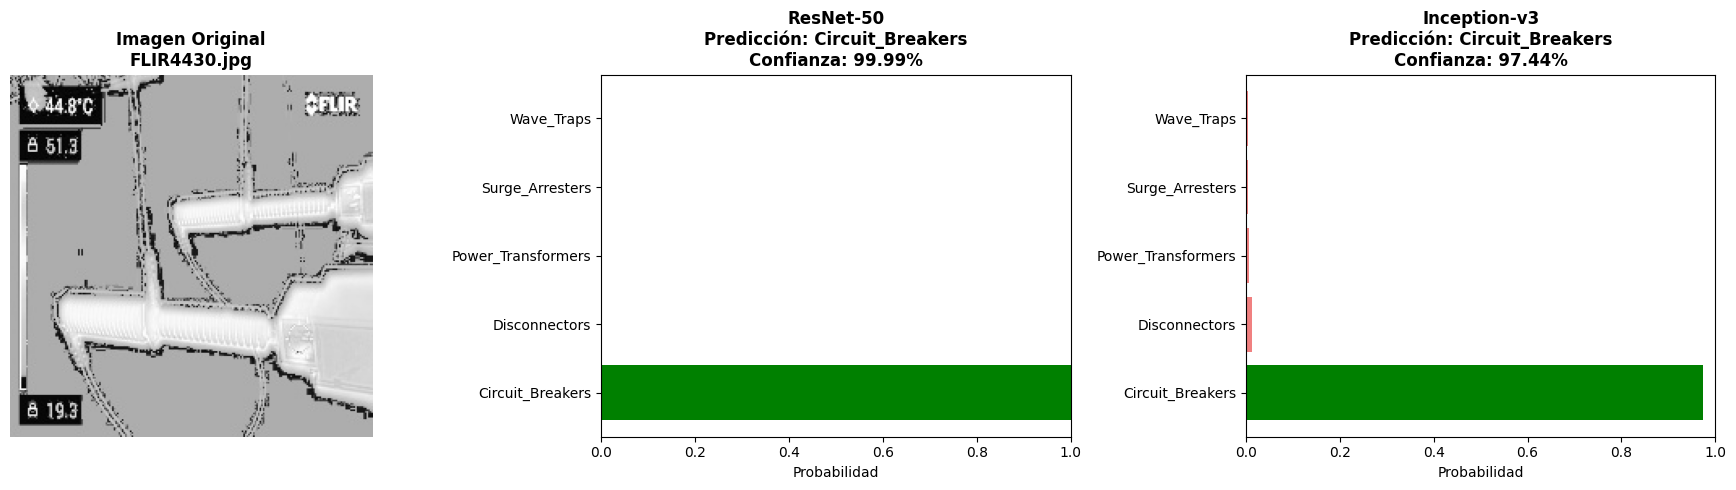


RESULTADOS DE PREDICCIÓN

ResNet-50:
  Clase predicha: Circuit_Breakers
  Confianza: 99.99%

Inception-v3:
  Clase predicha: Circuit_Breakers
  Confianza: 97.44%


In [10]:
# Predecir una imagen específica
if sample_images:
    test_image = sample_images[0]  # Cambiar índice para probar otras imágenes
    print(f"Prediciendo: {test_image}\n")
    results = predict_image(test_image)
    
    print("\n" + "="*60)
    print("RESULTADOS DE PREDICCIÓN")
    print("="*60)
    print(f"\nResNet-50:")
    print(f"  Clase predicha: {results['resnet']['class']}")
    print(f"  Confianza: {results['resnet']['confidence']:.2%}")
    print(f"\nInception-v3:")
    print(f"  Clase predicha: {results['inception']['class']}")
    print(f"  Confianza: {results['inception']['confidence']:.2%}")
else:
    print("No se encontraron imágenes de prueba")

### 6.2 Predecir múltiples imágenes


PREDICCIÓN 1/3


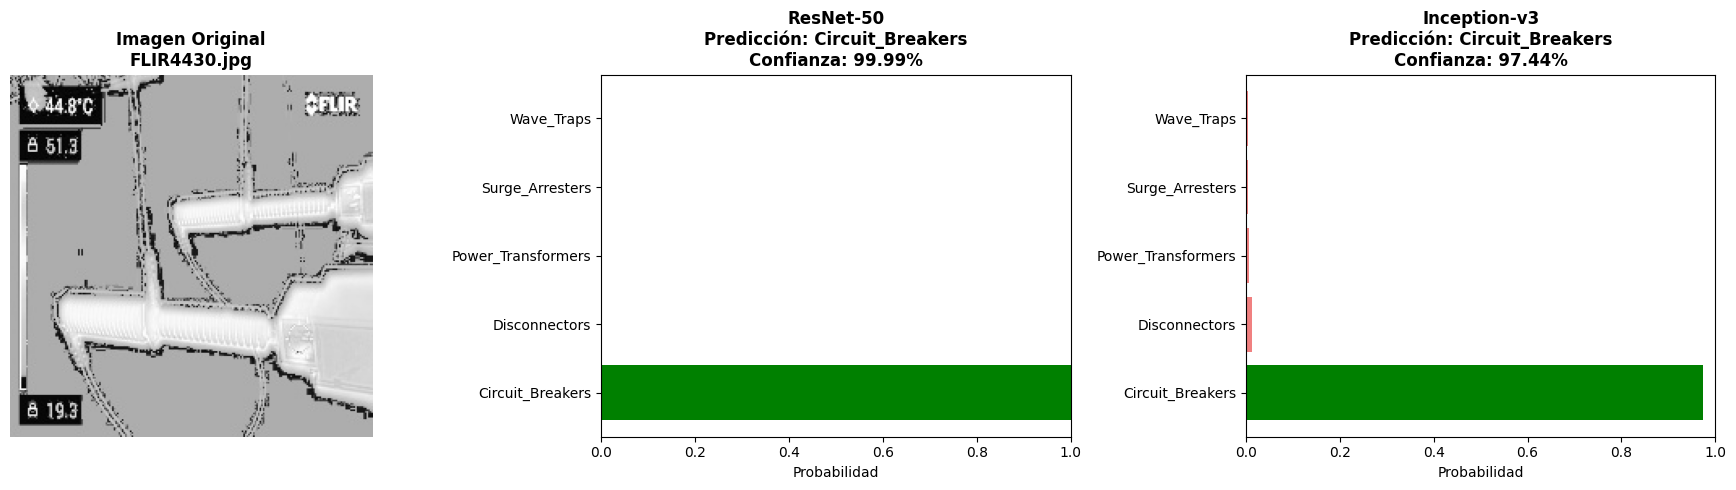


PREDICCIÓN 2/3


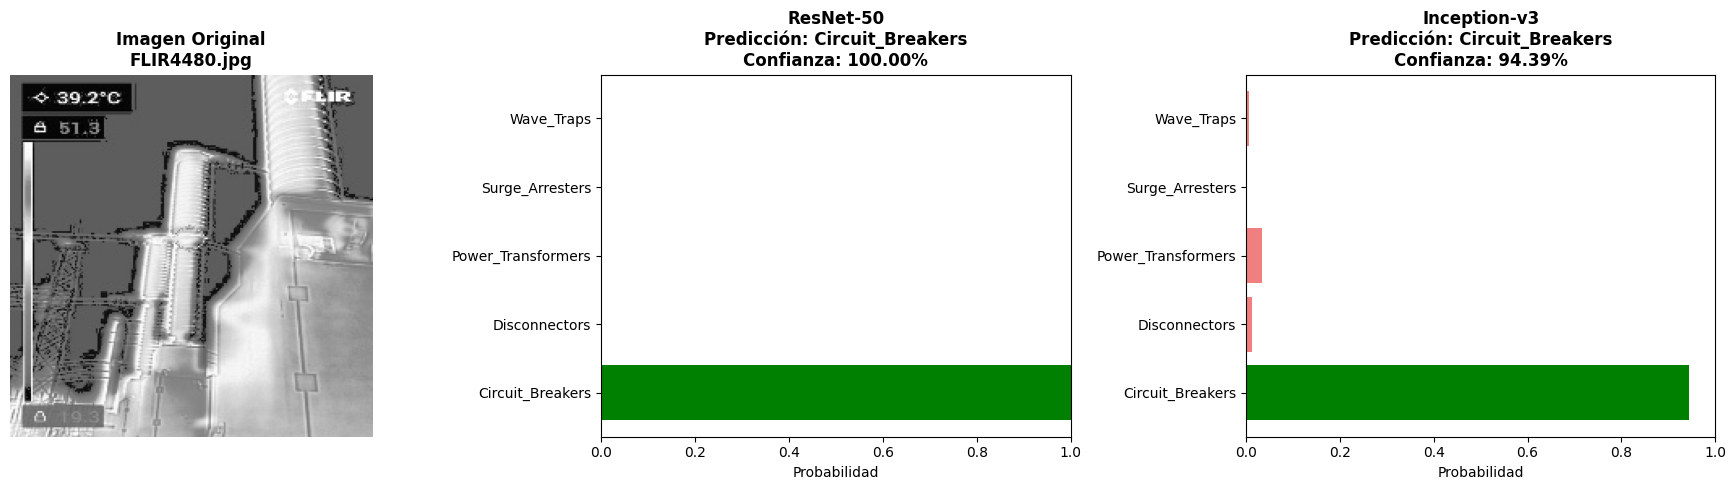


PREDICCIÓN 3/3


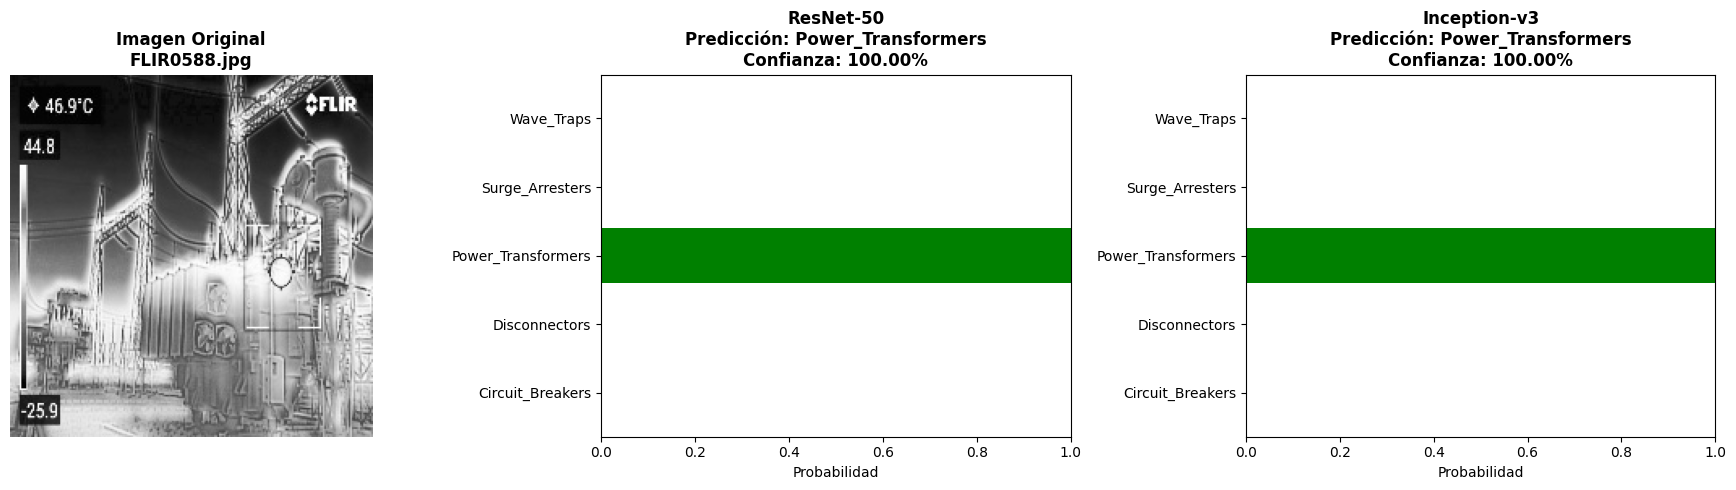

In [11]:
# Predecir varias imágenes
num_predictions = min(3, len(sample_images))

for i in range(num_predictions):
    print(f"\n{'='*80}")
    print(f"PREDICCIÓN {i+1}/{num_predictions}")
    print(f"{'='*80}")
    results = predict_image(sample_images[i])

### 6.3 Predecir desde una ruta personalizada

In [12]:
# Especificar ruta personalizada
custom_image_path = "ruta/a/tu/imagen.jpg"  # Cambiar por la ruta de tu imagen

# Descomentar para usar:
# if Path(custom_image_path).exists():
#     results = predict_image(custom_image_path)
# else:
#     print(f"Imagen no encontrada: {custom_image_path}")

## 7. Comparación de Modelos

In [13]:
# Evaluar acuerdo entre modelos
agreement_count = 0
total_count = min(10, len(sample_images))

print("Comparando predicciones de ambos modelos...\n")
print(f"{'Imagen':<30} {'Clase Real':<20} {'ResNet-50':<20} {'Inception-v3':<20} {'Acuerdo'}")
print("="*110)

for i in range(total_count):
    img_path = sample_images[i]
    true_class = img_path.parent.name
    
    results = predict_image(img_path, show_image=False)
    
    resnet_pred = results['resnet']['class']
    inception_pred = results['inception']['class']
    agree = "✓" if resnet_pred == inception_pred else "✗"
    
    if resnet_pred == inception_pred:
        agreement_count += 1
    
    print(f"{img_path.name:<30} {true_class:<20} {resnet_pred:<20} {inception_pred:<20} {agree}")

print("="*110)
print(f"\nAcuerdo entre modelos: {agreement_count}/{total_count} ({agreement_count/total_count:.1%})")

Comparando predicciones de ambos modelos...

Imagen                         Clase Real           ResNet-50            Inception-v3         Acuerdo
FLIR4430.jpg                   Circuit_Breakers     Circuit_Breakers     Circuit_Breakers     ✓
FLIR4480.jpg                   Circuit_Breakers     Circuit_Breakers     Circuit_Breakers     ✓
FLIR0588.jpg                   Power_Transformers   Power_Transformers   Power_Transformers   ✓
FLIR0520.jpg                   Power_Transformers   Power_Transformers   Power_Transformers   ✓
FLIR2796.jpg                   Surge_Arresters      Surge_Arresters      Surge_Arresters      ✓
FLIR2572.jpg                   Surge_Arresters      Power_Transformers   Power_Transformers   ✓
FLIR4000.jpg                   Disconnectors        Disconnectors        Disconnectors        ✓
FLIR4100.jpg                   Disconnectors        Disconnectors        Disconnectors        ✓
FLIR3486.jpg                   Wave_Traps           Wave_Traps           Wave_Traps  

## 8. Limpieza de GPU

In [14]:
# Liberar memoria GPU
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("✓ Cache de GPU limpiado")

✓ Cache de GPU limpiado
